## Organize data

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import os

outdir = './datasets/'
procdir = './activation_parcel'
infodir = './datasets_info/'

motion = pd.read_csv(infodir + 'activation_usability_20211001.csv', index_col=0)
pheno_data = pd.read_csv(infodir + 'pheno_export_20210928.csv', index_col=0)
#thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
thresholds = [0.9]

In [ ]:
# convert handedness to integers
pheno_data.loc[:,'righthanded']=3 # ambidexterous
pheno_data.loc[pheno_data['EHQ_Total']>48,'righthanded']=1 # right handed
pheno_data.loc[pheno_data['EHQ_Total']<-28,'righthanded']=0 # left handed

for thresh in thresholds:
    ## loop through and pull up usable data
    dataset_labels = open(outdir + 'firstleveldatalabels_thresh{0}_20211001.csv'.format(thresh), 'w')
    dataset_labels.write('sub,set,cond,movie,age,site,female,meanFD,righthanded\n')
    index = 0

    for sub in motion.index:
        for movie in ['TP','DM']:
            if motion.loc[sub, 'movie{0}_pcentlomo'.format(movie)] > thresh:
                for cond in ['pos_imca','neg_imca','brightness','rms']:
                    try:
                        temp = nib.load('{0}/{1}_movie{2}_setA_{3}.pscalar.nii'.format(procdir, sub, movie, cond)).get_fdata()
                        if index==0:
                            data = temp
                        else:
                            data = np.concatenate([data, temp], axis=0)
                        dataset_labels.write('{0},A,{1},{2},{3},{4},{5},{6},{7}\n'.format(sub, cond, movie, pheno_data.loc[sub[4:], 'Age'],
                                                                                          pheno_data.loc[sub[4:], 'site'], pheno_data.loc[sub[4:], 'Sex'], 
                                                                                          motion.loc[sub, 'movie{0}_meanFD'.format(movie)],
                                                                                          pheno_data.loc[sub[4:], 'righthanded']))
                        index = index + 1
                    except:
                        print('WARNING: {0}/{1}_movie{2}_setA_{3}.pscalar.nii not found.'.format(procdir, sub, movie, cond))

                for cond in ['pos_iaca','neg_iaca', 'global_intensity','brightness','rms']:
                    try:
                        temp = nib.load('{0}/{1}_movie{2}_setB_{3}.pscalar.nii'.format(procdir, sub, movie, cond)).get_fdata()
                        if index==0:
                            data = temp
                        else:
                            data = np.concatenate([data, temp], axis=0)
                        dataset_labels.write('{0},B,{1},{2},{3},{4},{5},{6},{7}\n'.format(sub, cond, movie, pheno_data.loc[sub[4:], 'Age'],
                                                                                          pheno_data.loc[sub[4:], 'site'], pheno_data.loc[sub[4:], 'Sex'], 
                                                                                          motion.loc[sub, 'movie{0}_meanFD'.format(movie)],
                                                                                          pheno_data.loc[sub[4:], 'righthanded']))
                        index = index + 1
                    except:
                        print('WARNING: {0}/{1}_movie{2}_setB_{3}.pscalar.nii not found.'.format(procdir, sub, movie, cond))

    dataset_labels.close()
    np.save(outdir + 'firstleveldata_thresh{0}_20210928.npy'.format(thresh), data)

# run models

In [28]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
from sklearn.svm import SVC, SVR
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, mean_squared_error
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold, permutation_test_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import date

today = date.today().strftime('%Y%m%d')

In [45]:
def cv_fit(model, X, Y, groups, cv):
    
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'r2'
    results = cross_validate(model, X=X, y=Y, groups=groups, n_jobs=10,
                       cv=cv, return_estimator=True, scoring=scoring)
    Y_pred = cross_val_predict(model, X=X, y=Y, groups=groups, n_jobs=10, cv=cv)
    train_scores = results['test_score']

    for i, a in enumerate(results['estimator']):
        c = np.expand_dims(a.coef_, axis=2)
        if i==0:
            weights = c
        else:
            weights = np.concatenate([weights, c], axis=2)
    
    estimators = results['estimator']
    weights = np.absolute(weights)
    mean_weights = np.mean(np.mean(weights, axis=2), axis=0, keepdims=True)
    return(estimators, weights, mean_weights, Y_pred, train_scores)

def predict_out(X, Y, estimators, kind):
    for i, a in enumerate(estimators):
        if i==0:
            Y_pred = a.predict(X)
            Y_test = Y
        else:
            Y_pred = np.concatenate([Y_pred, a.predict(X)], axis=0)
            Y_test = np.concatenate([Y_test, Y], axis=0)

    if kind=='classifier':
        accuracy = pd.DataFrame.from_dict(classification_report(Y_test, Y_pred, output_dict=True)).T
    elif kind=='regress':
        accuracy = pd.DataFrame(columns = ['stat','pval'])
        accuracy.loc['SpearmanR','stat'], accuracy.loc['SpearmanR','pval'] = scp.spearmanr(Y_pred, Y_test)
        accuracy.loc['PearsonR','stat'], accuracy.loc['PearsonR','pval'] = scp.pearsonr(Y_pred, Y_test)
        slope, intercept, r, p, se = scp.linregress(Y_pred, Y_test)
        accuracy.loc['LinearB','stat'] = slope
        accuracy.loc['LinearB','pval'] = p
        accuracy.loc['MSE','stat'] = mean_squared_error(Y_pred, Y_test)
    return(Y_pred, accuracy)

def make_confusion_matrix(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        fig = ConfusionMatrixDisplay.from_predictions(Y, Y_pred)
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    

def make_consistency_plot(Y, Y_pred, folds, outfile_name):
    if Y.shape[0] < Y_pred.shape[0]:
        Y_orig = Y
        for i in range(1, folds):
            Y = np.concatenate([Y,Y_orig], axis=0)

    if Y.shape[0] == Y_pred.shape[0]:
        plt.figure(figsize=(4,3))
        plt.scatter(Y, Y_pred)
        plt.xlabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig('{0}_{1}.svg'.format(outfile_name, today))
    else:
        print("ERROR: length mismatch")    
        
def make_cifti_weights(weights, mean_weights, sample_file, out_prefix):
    if weights.ndim==3:
        weights = np.mean(weights, axis=2)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,1,weights.shape[0], unit='second')
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(weights, (ax0, ax1))
    nib.save( weights_img, '{0}_SVM_weights_{1}.ptseries.nii'.format(out_prefix,today))

    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    weights_img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(np.mean(mean_weights, axis=0), axis=0), (ax0, ax1))
    nib.save( weights_img, '{0}_SVC_weights_mean_{1}.pscalar.nii'.format(out_prefix, today))

def create_mean_act_files(X, Y, sample_file, weights, out_folder, kind):
    ax0 = nib.load(sample_file).header.get_axis(0)
    ax1 = nib.load(sample_file).header.get_axis(1)
    
    weight_table = pd.DataFrame(index=ax1.name)
    weight_table['mean_weight'] = np.squeeze(weights)
    
    if kind=='classifier':
        activation = pd.DataFrame(X_train, columns = ax1.name, index=Y_train)
        mean_act = activation.groupby(activation.index.name).mean()
        weight_table[mean_act.index] = mean_act.T
    
    #elif kind='regress':
        # split data in quartiles for averaging
        
        # plot top 10% of weights activation versus Y
    
    weight_table.to_csv('{0}weights_activation_table_{1}.csv'.format(out_folder, today))
    
    for a in mean_act.index:
        img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(mean_act.loc[a,:], axis=0), (ax0, ax1))
        nib.save(img, '{0}mean_activation_{1}_{2}.pscalar.nii'.format(out_folder, a, today))
        
def permuted_p(model, X, Y, cv, groups, out_folder, n_perms=1000):

    # Perform permutation testing to get a p-value
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'r2'
        
    score, permutation_scores, pvalue = permutation_test_score(model, X, Y, scoring=scoring, 
                                                               cv=cv, n_permutations=n_perms, n_jobs=10, groups=groups)

    # Save a figure of the permutation scores
    plt.figure(figsize=(4,3))
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=1.5,label='Actual')
    plt.plot(2 * [1. / len(Y_train.unique())], ylim, '--k', linewidth=1.5, label='Chance')
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.tight_layout()
    plt.savefig('{0}permutation_plot_{1}.svg'.format(out_folder, today), transparent=True)
    plt.close()

    # save final pval/classifier score
    print('Classification score {0} (pvalue : {1})'.format(round(score,2), round(pvalue,3)))
    return(pvalue, permutation_scores)

def permuted_importance(estimators_list, X, Y, sample_file, out_folder):
    results = []
    if isinstance(estimators_list[0], SVC):
        scoring = 'accuracy'
    elif isinstance(estimators_list[0], SVR):
        scoring = 'r2'
    
    for a in estimators_list:
        r = permutation_importance(a, X, Y, scoring=scoring, n_repeats=50, n_jobs=10, random_state=42)
        results.append(r)

    for i, r in enumerate(results):
        if i==0:
            imp_scores = r['importances'].T
        else:
            imp_scores = np.concatenate([imp_scores, r['importances'].T], axis=0)
    
    # save dataframe with all the scores
    ax1 = nib.load(sample_file).header.get_axis(1)
    imp_score_table = pd.DataFrame(imp_scores.T, index=ax1.name)
    imp_score_table.to_csv('{0}permuted_importance_scores_{1}.csv'.format(out_folder, today))

    # save dataframe with mean scores
    imp_mean=np.mean(imp_scores, axis=0, keepdims=True)
    imp_table = pd.DataFrame(index=ax1.name)
    imp_table['mean_importance'] = np.squeeze(imp_mean)
    imp_table.to_csv('{0}mean_importance_{1}.csv'.format(out_folder, today))

    # plot importance scores
    imp_table['region'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='region', data=sorted_imp_table.iloc[:20,:], ci=None, color="#3B75AF")
    plt.xlabel('Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}top20importance_{1}.svg'.format(out_folder, today))
    
def permuted_network_importance(model, X, Y, sample_file, out_folder, model_score, n_perms=500):
    if isinstance(model, SVC):
        scoring = 'accuracy'
    elif isinstance(model, SVR):
        scoring = 'r2'
    
    # get network names and sizes
    parcel_labels = nib.load(sample_file).header.get_axis(1).name
    network_labels = []
    for s in parcel_labels:
        b = s.split('_')
        if len(b)<=2:
            network_labels.append('Subcortical')
        else:
            network_labels.append(b[1])
    network_labels = np.array(network_labels)
    network_names, network_sizes = np.unique(network_labels, return_counts=True)
    
    # set up permutations
    np.save(out_folder + 'temp.npy', X)
    rng = np.random.default_rng()
    perm_net_imp = pd.DataFrame(index=network_names)
    perm_netrand_imp = pd.DataFrame(index=network_names)

    perm_net_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    perm_netrand_imp = pd.DataFrame(index=network_names, columns=range(0,n_perms))
    
    model_score = np.mean(model_score)

    for i in range(0,n_perms):
        for net in network_names:
            # permute only the network-specific features
            net_perm_X = np.load(out_folder + 'temp.npy')
            netperm = net_perm_X[:,network_labels==net]
            netperm = rng.permutation(rng.permutation(netperm, axis=0), axis=1)
            net_perm_X[:,network_labels==net] = netperm
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_net_imp.loc[net,i] = perm_imp

        for n, count in enumerate(network_sizes):
            mask = np.full(X.shape[1], 0)
            mask[:count] = 1
            np.random.shuffle(mask)
            net_perm_X = np.load(out_folder + 'temp.npy')
            net_perm_X[:,mask] = rng.permutation(rng.permutation(X[:,mask], axis=0), axis=1)
            results = cross_validate(model, X=net_perm_X, y=Y, groups=groups, n_jobs=10, cv=cv, scoring=scoring)
            perm_imp = model_score - np.mean(results['test_score'])
            perm_netrand_imp.loc[network_names[n],i] = perm_imp

    os.remove(out_folder + 'temp.npy')
    imp_table = perm_net_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}network_importance_{1}.svg'.format(out_folder, today))

    imp_table = perm_netrand_imp.mean(axis=1).to_frame(name='mean_importance')
    imp_table['random_network'] = imp_table.index
    sorted_imp_table = imp_table.sort_values(by='mean_importance', axis=0, ascending=False)
    plt.figure(figsize=(6,5))
    sns.barplot(x='mean_importance', y='random_network', data=sorted_imp_table, ci=None, color="#3B75AF")
    plt.xlabel('Mean Change in {0}'.format(scoring))
    plt.ylabel('')
    plt.axvline(0, color='gray', clip_on=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig('{0}random_networksize_importance_{1}.svg'.format(out_folder, today))

In [46]:
## make class to handle model fitting
class permutedSVM:
    def __init__(self, model, cv, output_folder, folds=10, perm_iters=1000):
        self.cv = cv
        self.folds = folds
        self.perm_iters = perm_iters
        self.outfolder = output_folder
        self.random_state = model.random_state
        self.parcel_labels = None
        self.network_labels = None
        self.groups = None
        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        self.model = model
        self.estimators = None
        self.weights = None
        self.mean_weights = None
        self.Y_test_pred = None
        self.Y_train_pred = None
        self.test_score = None
        self.template_outfile = None
        self.perm_pval = None
        self.perm_scores = None
        self.train_scores = None
        
        os.makedirs(output_folder, exist_ok=True)

    def fit(self, X_train, Y_train, groups):
        self.X_train = X_train
        self.Y_train = Y_train
        self.groups = groups 
        estimators, weights, mean_weights, Y_pred, train_scores = cv_fit(self.model, self.X_train, self.Y_train, self.groups, self.cv)
        self.estimators = estimators
        self.weights = weights
        self.mean_weights = mean_weights
        self.Y_train_pred = Y_pred
        self.train_scores = train_scores
        return(self)
    
    def predict(self, X_test, Y_test, kind='classifier'):
        self.X_test = X_test
        self.Y_test = Y_test
        Y_pred, accuracy = predict_out(self.X_test, self.Y_test, self.estimators, kind=kind)
        self.Y_test_pred = Y_pred
        self.test_score = accuracy
        accuracy.to_csv(self.outfolder + 'performance_report.csv')
        return(self)

    def plot_confusion(self, outfile_name='confusion_matrix'):
        make_confusion_matrix(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_consistency(self, outfile_name='consistency_plot'):
        make_consistency_plot(self.Y_test, self.Y_test_pred, self.folds, self.outfolder + outfile_name)
    
    def plot_weights(self, template_outfile, out_prefix='model'):
        self.template_outfile = template_outfile
        make_cifti_weights(self.weights, self.mean_weights, self.template_outfile, self.outfolder + out_prefix)
        
    def make_weights_table_img(self, kind='classifier'):
        create_mean_act_files(self.X_train, self.Y_train, self.template_outfile, self.mean_weights, self.outfolder, kind)
        
    def calc_permuted_pvalue(self):
        pvalue, permutation_scores = permuted_p(self.model, self.X_train, self.Y_train, self.cv, self.groups, self.outfolder, n_perms=self.perm_iters)
        self.perm_pval = pvalue
        self.perm_scores = permutation_scores
        return(self)
    
    def get_perm_importance(self):
        permuted_importance(self.estimators, self.X_train, self.Y_train, self.template_outfile, self.outfolder)
        
    def get_perm_net_importance(self, n_perms=500):
        permuted_network_importance(self.model, self.X_train, self.Y_train, self.template_outfile, self.outfolder, self.train_scores, n_perms)


### load data and set mode params

In [53]:
## model parameters
thresh=0.8
folds = 10
cv = GroupKFold(n_splits=folds)
perm_iters = 1000
random_state = 42
model = SVC(kernel='linear', random_state=random_state)

## load model data
project_dir = '/Users/catcamacho/Box/CCP/HBN_study/proc/group/'
data_dir = project_dir + '/datasets/'
out_dir = project_dir + 'results/thresh{0}/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)
sample_file = project_dir + 'datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
data = np.load(data_dir + 'firstleveldata_thresh{0}_20210928.npy'.format(thresh))
data_labels = pd.read_csv(data_dir + 'firstleveldatalabels_thresh{0}_20211001.csv'.format(thresh), index_col=None)

# relabel the pos/neg variables for clarity
data_labels = data_labels.replace('pos_imca','positive')
data_labels = data_labels.replace('pos_iaca','positive')
data_labels = data_labels.replace('neg_imca','negative')
data_labels = data_labels.replace('neg_iaca','negative')

# split training and testing data by site
full_train = data[data_labels['site']=='cbic']
full_train_labels = data_labels[data_labels['site']=='cbic']
full_train_labels.to_csv(out_dir + 'training_labels{0}.csv'.format(today))
full_test = data[data_labels['site']=='rubic']
full_test_labels = data_labels[data_labels['site']=='rubic']
full_test_labels.to_csv(out_dir + 'testing_labels{0}.csv'.format(today))

### Run models that discriminate low-level features

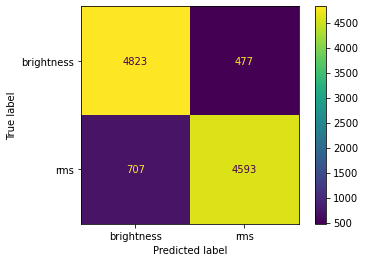

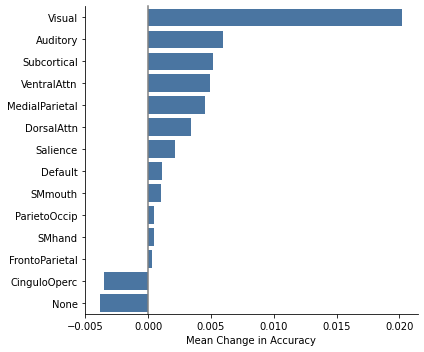

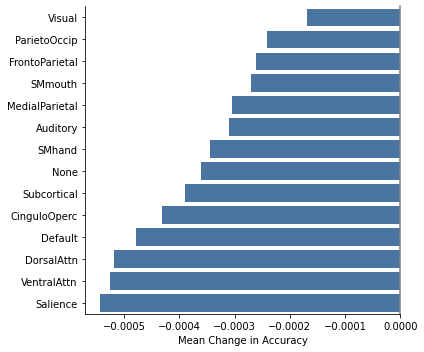

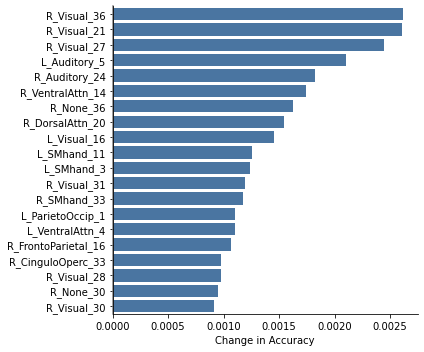

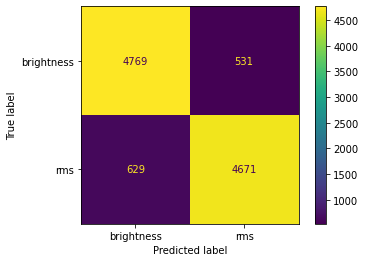

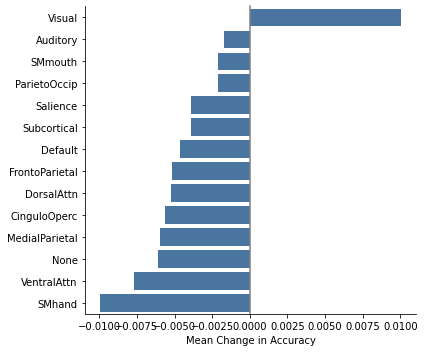

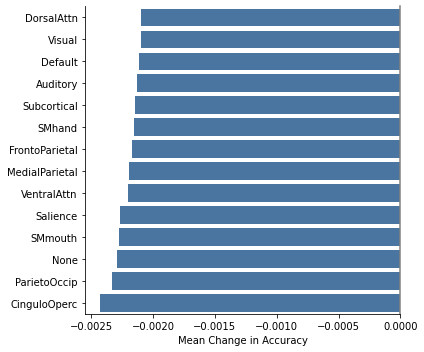

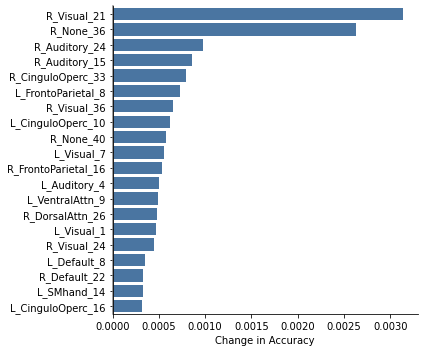

In [54]:
# include positive/negative only from both movies.  Repeat for each set A and B
dataset = 'lowlevel'

for s in ['A','B']:
    #set specific variables
    X_train = full_train[(full_train_labels['set']==s) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
    Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
    groups = full_train_labels['sub'][(full_train_labels['set']==s) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
    X_test = full_test[(full_test_labels['set']==s) & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
    Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
    out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)
    
    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.plot_confusion()
    svc.plot_weights(sample_file)
    svc.make_weights_table_img()
    svc.get_perm_net_importance(n_perms=500)
    svc.get_perm_importance()
    #svc.calc_permuted_pvalue()
    #pickle.dump(svc, open(svc.outfolder + 'model.sav', 'w'))

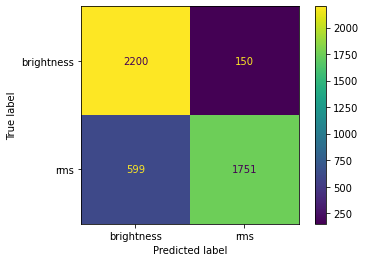

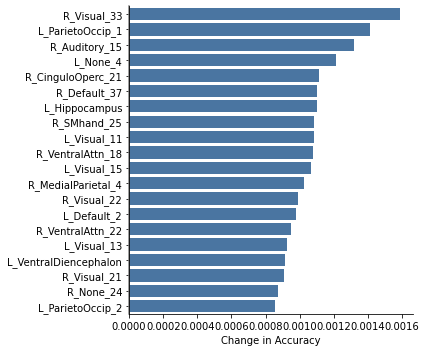

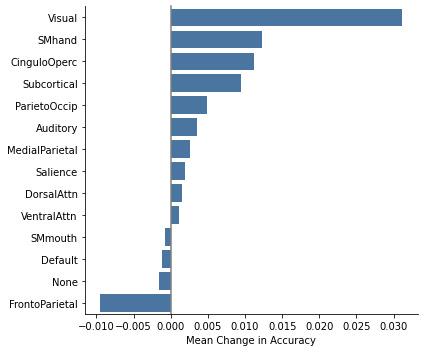

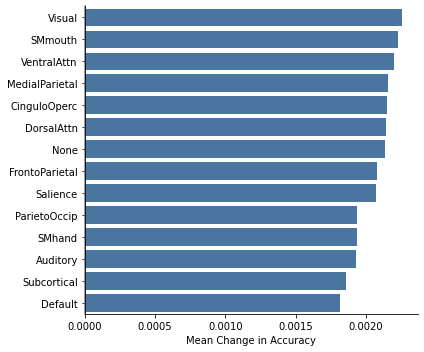

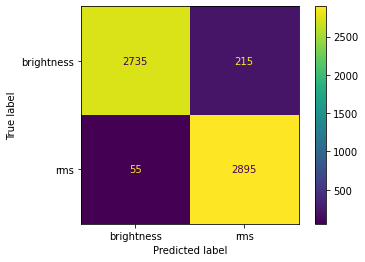

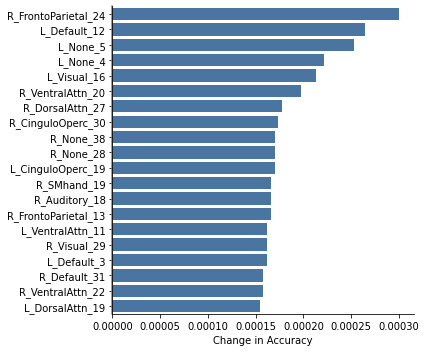

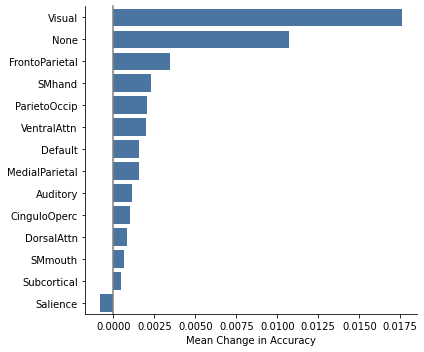

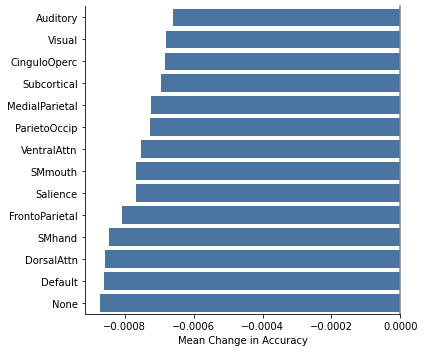

In [56]:
# train and test within one movie

for mov in ['DM', 'TP']:
    dataset = 'lowlevel_movie{0}'.format(mov)
    for s in ['A']:#,'B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']==mov) & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']==mov) & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        svc.plot_weights(sample_file)
        svc.make_weights_table_img()
        svc.get_perm_importance()
        svc.get_perm_net_importance(n_perms=500)
        #svc.calc_permuted_pvalue()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

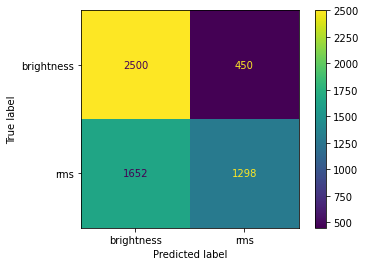

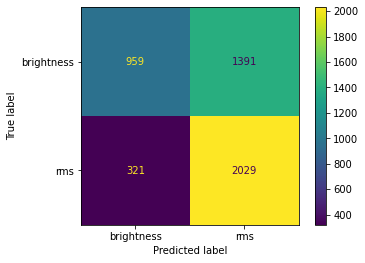

In [57]:
# train within one movie and test with the other.
dataset = 'lowlevel_trainDMtestTP'
for s in ['A']:#,'B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        Y_test = full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))


dataset = 'lowlevel_trainTPtestDM'
for s in ['A']:#,'B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='brightness') | (full_train_labels['cond']=='rms'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='brightness') | (full_test_labels['cond']=='rms'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

### Run models that discriminate positive from negative

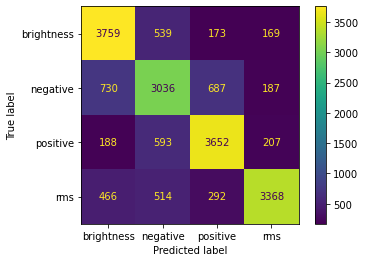

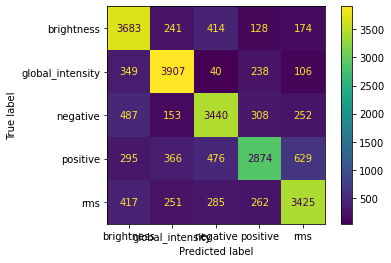

In [24]:
# include all data from both movies. repeat for each set A and B
dataset = 'allconds'

for s in ['A','B']:
    #set specific variables
    X_train = full_train[full_train_labels['set']==s]
    Y_train = full_train_labels['cond'][full_train_labels['set']==s]
    groups = full_train_labels['sub'][full_train_labels['set']==s]
    X_test = full_test[full_test_labels['set']==s]
    Y_test =full_test_labels['cond'][full_test_labels['set']==s]
    out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)
    
    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.plot_confusion()
    svc.plot_weights(sample_file)
    svc.make_weights_table_img()
    #svc.get_perm_importance()
    #svc.calc_permuted_pvalue()
    #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

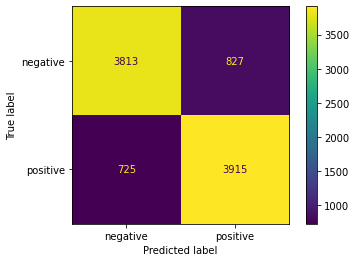

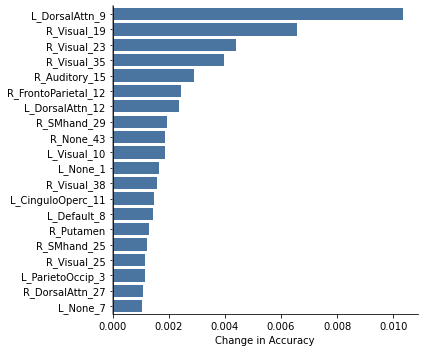

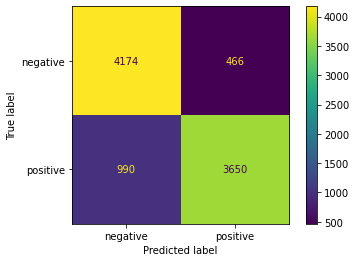

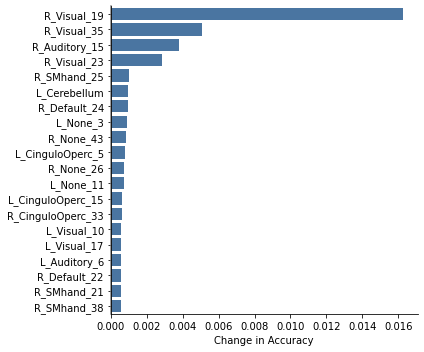

In [25]:
# include positive/negative only from both movies.  Repeat for each set A and B
dataset = 'emo'

for s in ['A','B']:
    #set specific variables
    X_train = full_train[(full_train_labels['set']==s) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    groups = full_train_labels['sub'][(full_train_labels['set']==s) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
    X_test = full_test[(full_test_labels['set']==s) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
    Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
    out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)
    
    svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
    svc = svc.fit(X_train, Y_train, groups)
    svc = svc.predict(X_test, Y_test)
    svc.plot_confusion()
    svc.plot_weights(sample_file)
    svc.make_weights_table_img()
    #svc.get_perm_net_importance(n_perms=500)
    svc.get_perm_importance()
    #svc.calc_permuted_pvalue()
    #pickle.dump(svc, open(svc.outfolder + 'model.sav', 'w'))

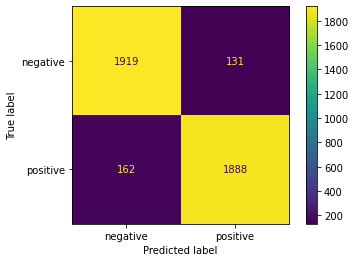

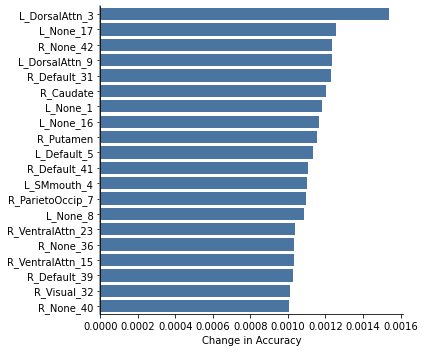

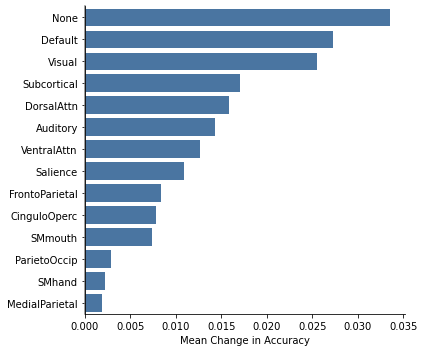

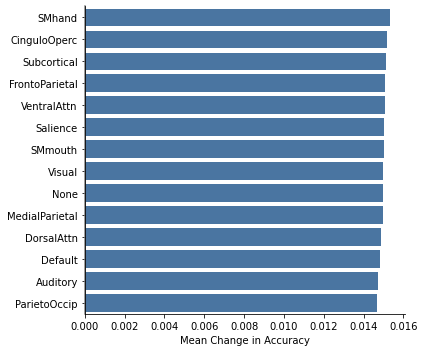

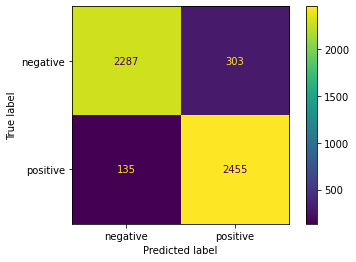

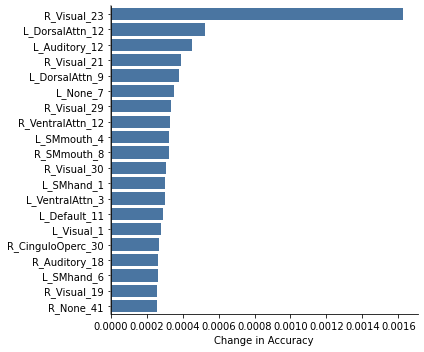

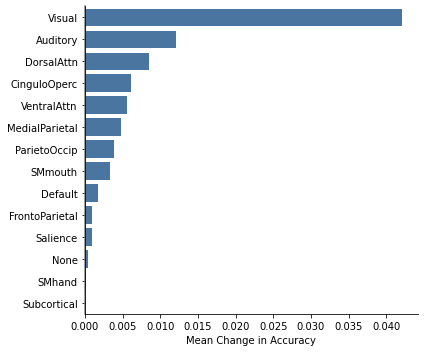

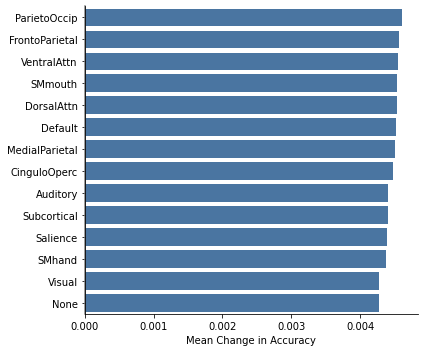

In [26]:
# train and test within one movie

for mov in ['DM', 'TP']:
    dataset = 'emo_movie{0}'.format(mov)
    for s in ['A']:#,'B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']==mov) & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']==mov) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']==mov) & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        svc.plot_weights(sample_file)
        svc.make_weights_table_img()
        svc.get_perm_importance()
        svc.get_perm_net_importance(n_perms=500)
        #svc.calc_permuted_pvalue()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

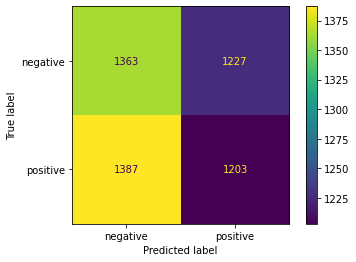

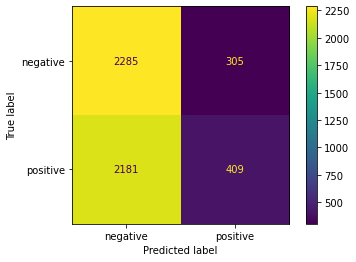

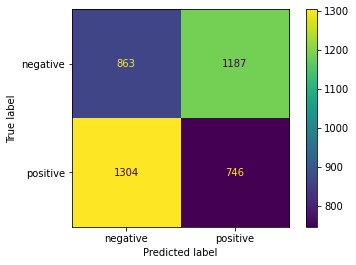

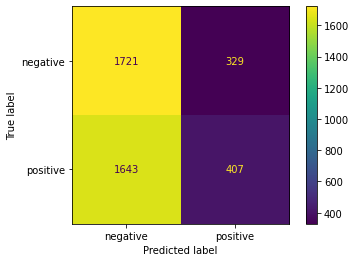

In [27]:
# train within one movie and test with the other.
dataset = 'emo_trainDMtestTP'
for s in ['A','B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']=='DM') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']=='TP') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))


dataset = 'emo_trainTPtestDM'
for s in ['A','B']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        Y_train = full_train_labels['cond'][(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['movie']=='TP') & ((full_train_labels['cond']=='positive') | (full_train_labels['cond']=='negative'))]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        Y_test =full_test_labels['cond'][(full_test_labels['set']==s) & (full_test_labels['movie']=='DM') & ((full_test_labels['cond']=='positive') | (full_test_labels['cond']=='negative'))]
        out_folder = out_dir+'set{0}_data-{1}/'.format(s, dataset)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test)
        svc.plot_confusion()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

### models that examine associations with age

In [47]:
## model parameters
thresh=0.8
folds = 10
cv = GroupKFold(n_splits=folds)
perm_iters = 1000
random_state = 42
model = SVR(kernel='linear')

## load model data
project_dir = '/Users/catcamacho/Box/CCP/HBN_study/proc/group/'
data_dir = project_dir + '/datasets/'
out_dir = project_dir + 'results/thresh{0}/'.format(thresh)
os.makedirs(out_dir,exist_ok=True)
sample_file = project_dir + 'datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
data = np.load(data_dir + 'firstleveldata_thresh{0}_20210928.npy'.format(thresh))
data_labels = pd.read_csv(data_dir + 'firstleveldatalabels_thresh{0}_20211001.csv'.format(thresh), index_col=None)

# relabel the pos/neg variables for clarity
data_labels = data_labels.replace('pos_imca','positive')
data_labels = data_labels.replace('pos_iaca','positive')
data_labels = data_labels.replace('neg_imca','negative')
data_labels = data_labels.replace('neg_iaca','negative')

# split training and testing data by site
full_train = data[data_labels['site']=='cbic']
full_train_labels = data_labels[data_labels['site']=='cbic']
full_train_labels.to_csv(out_dir + 'training_labels{0}.csv'.format(today))
full_test = data[data_labels['site']=='rubic']
full_test_labels = data_labels[data_labels['site']=='rubic']
full_test_labels.to_csv(out_dir + 'testing_labels{0}.csv'.format(today))

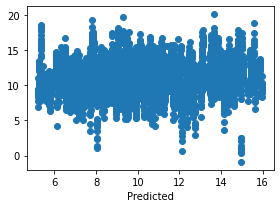

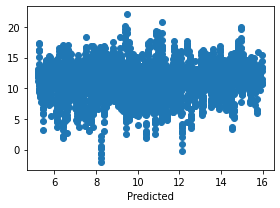

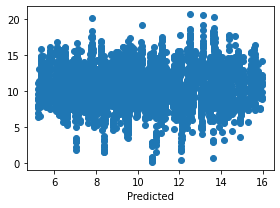

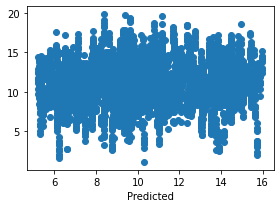

In [48]:
# include all data from both movies. repeat for each set A and B
dataset = 'emo'

for s in ['A','B']:
    for emo in ['positive','negative']:
        #set specific variables
        X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['cond']==emo)]
        Y_train = full_train_labels['age'][(full_train_labels['set']==s) & (full_train_labels['cond']==emo)]
        groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['cond']==emo)]
        X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['cond']==emo)]
        Y_test =full_test_labels['age'][(full_test_labels['set']==s) & (full_test_labels['cond']==emo)]
        out_folder = out_dir+'set{0}_data-{1}_{2}/'.format(s, dataset, emo)

        svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
        svc = svc.fit(X_train, Y_train, groups)
        svc = svc.predict(X_test, Y_test, kind='regress')
        svc.plot_consistency()
        svc.plot_weights(sample_file)
        #svc.make_weights_table_img()
        #svc.calc_permuted_pvalue()
        #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))

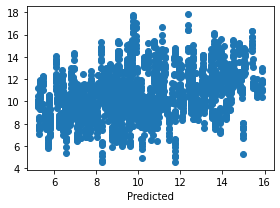

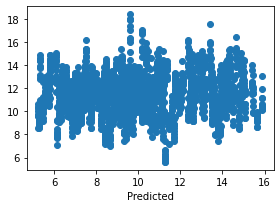

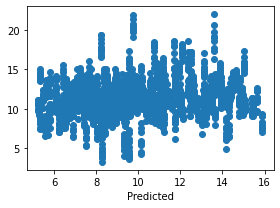

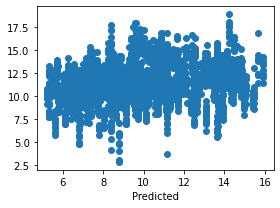

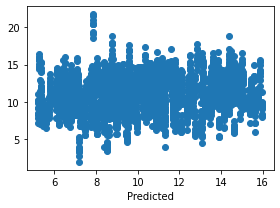

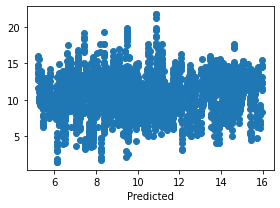

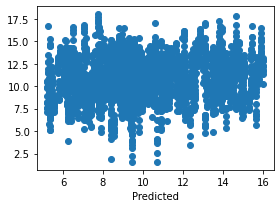

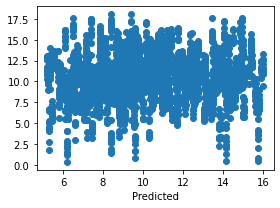

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py", line 205, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "/Users/catcamacho/Libr

In [49]:
dataset = 'emo'
for mov in ['DM','TP']:
    for s in ['A','B']:
        for emo in ['positive','negative']:
            #set specific variables
            X_train = full_train[(full_train_labels['set']==s) & (full_train_labels['cond']==emo) & (full_train_labels['movie']==mov)]
            Y_train = full_train_labels['age'][(full_train_labels['set']==s) & (full_train_labels['cond']==emo) & (full_train_labels['movie']==mov)]
            groups = full_train_labels['sub'][(full_train_labels['set']==s) & (full_train_labels['cond']==emo) & (full_train_labels['movie']==mov)]
            X_test = full_test[(full_test_labels['set']==s) & (full_test_labels['cond']==emo)& (full_test_labels['movie']==mov)]
            Y_test =full_test_labels['age'][(full_test_labels['set']==s) & (full_test_labels['cond']==emo) & (full_test_labels['movie']==mov)]
            out_folder = out_dir+'set{0}_data-{1}_{2}_{3}/'.format(s, dataset, mov, emo)

            svc = permutedSVM(model=model, cv=cv, output_folder=out_folder)
            svc = svc.fit(X_train, Y_train, groups)
            svc = svc.predict(X_test, Y_test, kind='regress')
            svc.plot_consistency()
            svc.plot_weights(sample_file)
            #svc.make_weights_table_img()
            #svc.calc_permuted_pvalue()
            #pickle.dump(self, open(svc.outfolder + 'model.sav', 'w'))